In [5]:
import boto3
import pandas as pd
import io

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
s3 = boto3.client('s3')

In [21]:
bucket_name = 'aai-540-final-data'
response = s3.list_objects_v2(Bucket=bucket_name)
for obj in response['Contents']:
    print(obj['Key'])

data/dev.tsv
data/goemotions_1.csv
data/goemotions_2.csv
data/goemotions_3.csv
data/test.tsv
data/train.tsv


In [32]:
column_names = ['text', 'emotions', 'id']
train_data_obj = s3.get_object(Bucket=bucket_name, Key='data/train.tsv')
train_df = pd.read_csv(io.BytesIO(train_data_obj['Body'].read()), delimiter='\t', header=None, names=column_names)

In [24]:
len(train_df)

43409

In [33]:
train_df.head()

,text,emotions,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [29]:
test_data_obj = s3.get_object(Bucket=bucket_name, Key='data/test.tsv')
test_df = pd.read_csv(io.BytesIO(test_data_obj['Body'].read()), delimiter='\t')

dev_data_obj = s3.get_object(Bucket=bucket_name, Key='data/dev.tsv')
val_df = pd.read_csv(io.BytesIO(dev_data_obj['Body'].read()), delimiter='\t')

In [2]:
len(test_df)

5427

In [3]:
len(val_df)

5426

In [7]:
# initial data exploration

# Calculating text length in terms of words and characters
word_count = train_df['text'].apply(lambda x: len(str(x).split()))
char_count = train_df['text'].apply(lambda x: len(str(x)))

# Calculating the average word length
def avg_word(sentence):
    words = sentence.split()
    return sum(len(word) for word in words)/len(words)

avg_word_len = train_df['text'].apply(lambda x: avg_word(x))

# Word frequency
freq = pd.Series(' '.join(train_df['text']).split()).value_counts()[:20]

# Display basic statistics and the most frequent words
print('Word Count: ', word_count.describe())
print('Character Count: ', char_count.describe())
print('Average Word Length: ', avg_word_len.describe())
print('Most Frequent Words: ', freq)

Word Count:  count    43410.000000
mean        12.840175
std          6.701597
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: text, dtype: float64
Character Count:  count    43410.000000
mean        68.400875
std         36.721898
min          2.000000
25%         38.000000
50%         65.000000
75%         96.000000
max        703.000000
Name: text, dtype: float64
Average Word Length:  count    43410.000000
mean         4.473930
std          0.943552
min          1.000000
25%          3.950000
50%          4.357143
75%          4.846154
max         49.285714
Name: text, dtype: float64
Most Frequent Words:  the       16294
I         14933
to        12267
a         11920
and        8186
is         7799
you        7002
of         6955
that       6322
[NAME]     5743
in         5459
for        5459
it         5162
this       4330
was        3764
be         3398
on         3309
my         3129
have       3107
like       3

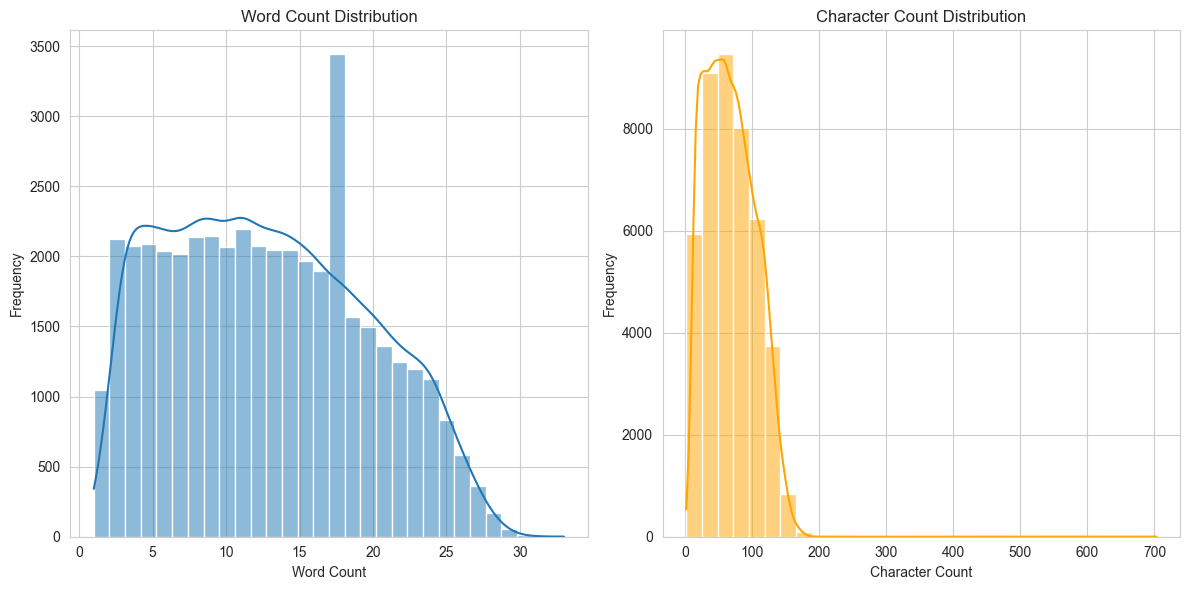

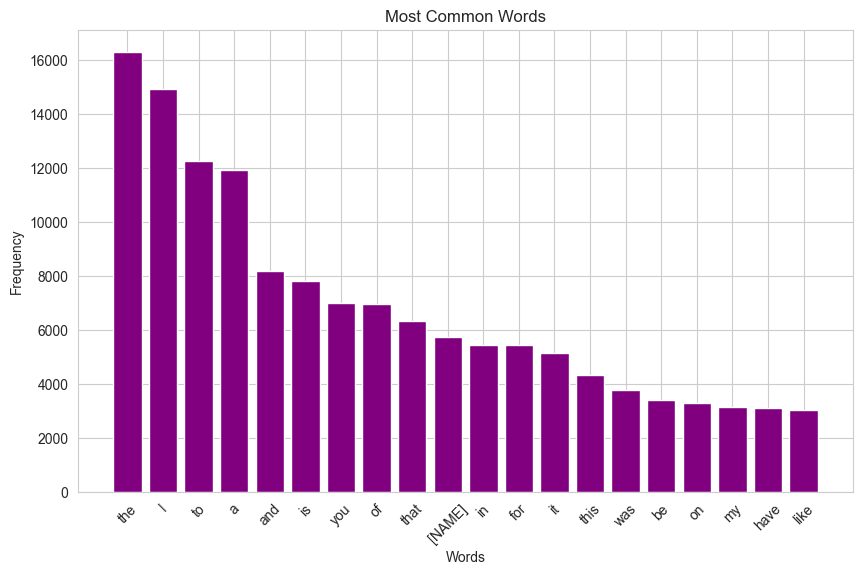

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the aesthetics for the plots
sns.set_style("whitegrid")

# Plot for Text Length Distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(word_count, bins=30, kde=True)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(char_count, bins=30, kde=True, color='orange')
plt.title('Character Count Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Bar plot for most common words
most_common_words = dict(freq)
plt.figure(figsize=(10, 6))
plt.bar(most_common_words.keys(), most_common_words.values(), color='purple')
plt.title('Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()